# Self-Supervision with FastAI
> A tutorial of rotation-based self-supervision using FastAI2 & PyTorch!



# Introduction

This notebook is an introduction to self-supervised learning. In short, self-supervised learning has 2 components:

1. Pretrain on a pretext task, where the labels can come from the data itself
2. Transfer the features, and train on the actual classification labels!

>"What if we can get labels for free for unlabelled data and train unsupervised dataset in a supervised manner? We can achieve this by framing a supervised learning task in a special form to predict only a subset of information using the rest. In this way, all the information needed, both inputs and labels, has been provided. This is known as self-supervised learning." - Lilian Weng

Using FastAI2, we'll use rotation as a pretext task for learning representations/features of our data. 


# Experiment Layout

In this notebook, we will be using the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database).


1. Train a model on a rotation prediction task.
  - We will use *all* the training data for rotation prediction.
  - Input: A rotated image.
  - Target/Label: Classify the amount of degrees rotated.
  - Our model should learn useful features that can transfer well for a classification task.
  - (The model should learn what digits look like in order to be able to successfully predict the amount of rotation).

2. Transfer our rotation pretraining features to solve the classification task with *much fewer* labels, < 1% of the original data.
  - Input: A normal image.
  - Target/Label: The images' *original* categorical label.
  - Classification accuracy should be decent, even with only using < 1% of the original data.

3. Train a classifier from scratch on the same amount of data used in experiment 2.
  - Input: A normal image.
  - Target/Label: The images' *original* categorical label.
  - Classification accuracy should be low (lack of transfer learning & too few labeled data!)
  - Model may overfit.  

# FastAI Vision Model Creation Methods

> Warning: This Jupyter notebook runs with fastai2! Make sure you have it installed, use the cell below to install it :)

In [ ]:
!pip install fastai --upgrade

# Uncomment and run the below line to get a fresh install of fastai, if needed

> Important: Pay attention! It's important. We will be using a small ConvNet to test our self-supervised learning method. The architecture is defined below in `simple_arch`.

Note that `simple_model` takes in one argument, `pretrained`. This is to allow FastAI to pass `pretrained=True` or `pretrained=False` when creating the model body! Below are some use cases of when we would want `pretrained=True` or `pretrained=False`.

1. `pretrained=False` = For training a new model on our rotation prediction task.
2. `pretrained=True` = For transferring the learnt features from our rotation task pretraining to solve a classification task.
3. `pretrained=False` = For training a new model from scratch on the main classification task (no transfer learning).

In [ ]:
from fastai.vision.all import *

In [ ]:
#collapse-show
def simple_model(pretrained=False):
    # Note that FastAI will automatically cut at pooling layer for the body!
    model = nn.Sequential(
        nn.Conv2d(1, 4, 3, 1)
        #you code here
    )
    if (pretrained):
        print("Loading pretrained model...")
        pretrained_weights = torch.load(save_path/'rot_pretrained.pt')
        print(model.load_state_dict(pretrained_weights))
    return model

> The follow below code snippets are examples of how FastAI creates CNNs. Every model will have a *body* and a *head*

In [ ]:
#collapse-show
model = create_body(simple_model(), cut=9, pretrained=False)
model

In [ ]:
#collapse-show
head = create_head(nf=32, n_out=8, lin_ftrs=[]) #nf - number of features
head

In [ ]:
#collapse-show
# Note that FastAI automatically determines nf for the head!
model = create_vision_model(arch=simple_model, pretrained=False, custom_head = head, cut = noop, n_out=8, lin_ftrs=[])
model

# PyTorch Rotation/Classification Self-Supervised Dataset

In [ ]:
# --- Functions to convert between Torch Tensors and PIL Images ---
import torchvision
tensorToImage = torchvision.transforms.ToPILImage()
imageToTensor = torchvision.transforms.ToTensor()

In [ ]:
#collapse-hide
# Uncomment and run the below lines if torchvision has trouble downloading MNIST (in the next cell)

# !wget -P data/MNIST/raw/ http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
# !wget -P data/MNIST/raw/ http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
# !wget -P data/MNIST/raw/ http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
# !wget -P data/MNIST/raw/ http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

In [ ]:
# Download MNIST dataset from PyTorch if not downloaded already!
#torchvision.datasets.MNIST('data/', download=True)
torchvision.datasets.MNIST('data/', train=True, transform=None, target_transform=None, download=True)
!mkdir data/MNIST/Processed
!wget https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/week08-self_supervision/MNIST/processed/test.pt -O data/MNIST/Processed/test.pt
!wget https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/week08-self_supervision/MNIST/processed/training.pt -O data/MNIST/Processed/training.pt

Below we define a dataset, here's the docstring:

A Dataset for Rotation-based Self-Supervision! Images are rotated clockwise.
- `file` - MNIST processed .pt file.
- `pct` - percent of data to use
- `classification` - False=Use rotation labels. True=Use original classification labels.

In [ ]:
#collapse-hide
class Custom_Dataset_MNIST():
    '''
    A Dataset for Rotation-based Self-Supervision! Images are rotated clockwise.
    - file - MNIST processed .pt file.
    - pct - percent of data to use
    - classification - False=Use rotation labels. True=Use original classification labels.
    '''
    
    def __init__(self, file, pct, classification):
        
        data = torch.load(file)
        self.imgs = data[0]
        self.labels = data[1]
        self.pct = pct
        self.classification = classification
                    
        slice_idx = int(len(self.imgs)*self.pct)
        self.imgs = self.imgs[:slice_idx]
                    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = self.imgs[idx].unsqueeze(0)
        img = tensorToImage(img)
        img = img.resize((32, 32), resample=1)
        img = imageToTensor(img)
        
        if (not self.classification):
            # 4 classes for rotation
            degrees = [0, 45, 90, 135, 180, 225, 270, 315]
            rand_choice = random.randint(0, len(degrees)-1)
            
            img = tensorToImage(img)
            img = img.rotate(degrees[rand_choice])
            img = imageToTensor(img)
            return img, torch.tensor(rand_choice).long()
        
        return img, self.labels[idx]
    
    def show_batch(self, n=3):
        fig, axs = plt.subplots(n, n)
        fig.tight_layout()
        for i in range(n):
            for j in range(n):
                rand_idx = random.randint(0, len(self)-1)
                img, label = self.__getitem__(rand_idx)
                axs[i, j].imshow(tensorToImage(img), cmap='gray')
                if self.classification:
                    axs[i, j].set_title('Label: {0} (Digit #{1})'.format(label.item(), label.item()))
                else:
                    axs[i, j].set_title('Label: {0} ({1} Degrees)'.format(label.item(), label.item()*45))
                axs[i, j].axis('off')

# Rotation Prediction Data

> Important: 60k training data and 10k validation data!

In [ ]:
import torch
# Make rotation datasets
train_ds = Custom_Dataset_MNIST('data/MNIST/Processed/training.pt', pct=1.0, classification=False)
valid_ds = Custom_Dataset_MNIST('data/MNIST/Processed/test.pt', pct=1.0, classification=False)
print('{0} Training Samples | {1} Validation Samples'.format(len(train_ds), len(valid_ds)))

10000 Training Samples | 10000 Validation Samples


> Note: Notice that our labels don't correspond to digits! They correspond to the amount of degrees rotated! Specifically from this predefined set: `[0, 45, 90, 135, 180, 225, 270, 315]`

In [ ]:
from fastai.data.core import DataLoaders
dls = DataLoaders.from_dsets(train_ds, valid_ds).cuda()

# Override the show_batch function of dls to the one used in our dataset!
dls.show_batch = train_ds.show_batch

# We have 8 classes! [0, 1, 2, 3, 4, 5, 6, 7] that correspond to the [0, 45, 90, 135, 180, 225, 270, 315] degrees of rotation.
dls.c = 8

dls.show_batch()

# FastAI Vision Learner [Rotation]

In [ ]:
# Create a config for our model's head!
rotation_head = create_head(nf=32, n_out=8, lin_ftrs=[])
rotation_head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=64, out_features=8, bias=False)
)

> Note: We want to measure `top_2_accuracy` along with regular (top_1) accuracy, because there are hard-cases where it's understandable why our model got it wrong. For example: '0' rotated 90 or 270 degrees, or '1' rotated 0 or 180 degrees. (They can look the same!)

In [ ]:
# Top_2 accuracy is a nice metric for hard-cases:
# - A zero rotated 90 or 270 degrees?
# - A one rotated 0 or 180 degrees?
# etc :P

top_2_accuracy = lambda inp, targ: top_k_accuracy(inp, targ, k=2)
top_2_accuracy

<function __main__.<lambda>(inp, targ)>

Here, we train a model on the rotation prediction task!

In [ ]:
learner = Learner(dls, model,
                      loss_func=CrossEntropyLossFlat(),
                      metrics=[accuracy, top_2_accuracy])

learner.model

In [ ]:
learner.summary()

In [ ]:
learner.lr_find()

In [ ]:
learner.fit_one_cycle(5, lr_max=1e-2)

> Important: We were able to achieve 76.2% top-1 accuracy, and 96.8% top-2 accuracy after just 5 epochs! Now we want to grab our `model` from our `Learner`, and save the body of it!

> Note: Our `model` has two components, the *body* and the *head*. `model` is a list of size 2, where `model[0]` is the body, and `model[1]` is the head!

In [ ]:
# Access the body of our model
trained_body = learner.model[0]
trained_body

> Tip: To save a model in PyTorch, save it's `state_dict` function! You can use `model.load_state_dict` to re-load the weights.

In [ ]:
# Make save directory if it doesn't exist
save_path = Path('rotation_cps/')
if not save_path.exists():
    save_path.mkdir()

# Save the rotation-pretraining weights of our model body
torch.save(trained_body.state_dict(), save_path/'rot_pretrained.pt')

# Original Classification Data

Now that we have pretrained our model on the rotation prediction task, we want to switch over to the original labeled data for the classification task.

> Important: We're only using 180 samples for training!

In [ ]:
# Use 0.3% classification labeled data for training!
# Use 100% classification labeled data for validation!
train_ds = Custom_Dataset_MNIST('data/MNIST/Processed/training.pt', pct=0.03, classification=True)
valid_ds = Custom_Dataset_MNIST('data/MNIST/Processed/test.pt', pct=1.0, classification=True)
print('{0} Training Samples | {1} Validation Samples'.format(len(train_ds), len(valid_ds)))

300 Training Samples | 10000 Validation Samples


> Note: Notice the labels now correspond to the digit class!

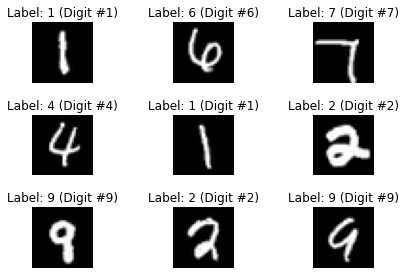

In [ ]:
from fastai.data.core import DataLoaders
dls = DataLoaders.from_dsets(train_ds, valid_ds).cuda()
dls.show_batch = train_ds.show_batch

# We have 10 classes! One for each digit label!
dls.c = 10

dls.show_batch()

# FastAI Vision Learner [Transfer-Classification]

Here we will toggle `pretrained=True` to transfer our rotation prediction features, and train on the original 180 labeled data.

Fast-ai training functions [Fine-tune](https://docs.fast.ai/callback.schedule.html#learner.fine_tune), [Fit_one_cycle](https://docs.fast.ai/callback.schedule.html#learner.fit_one_cycle).

In [ ]:
#collapse-show
classification_head = create_head(nf=32, n_out=10, lin_ftrs=[])
classification_head

> Note: We have `n_out=10` because of the 10 different digit classes

In [ ]:
model = create_vision_model(arch=simple_model, pretrained=True, custom_head = classification_head, cut = noop, n_out=10, lin_ftrs=[])

Loading pretrained model...
<All keys matched successfully>


In [ ]:
#collapse-show
#retrained=True will load the saved rotation pretraining weights into our model's body!
# See simple_arch() function definition for more details!
learner = Learner(dls, model,
                      loss_func=CrossEntropyLossFlat(),
                      metrics=[accuracy, top_2_accuracy])

learner.model[0]

In [ ]:
learner.freeze()
learner.lr_find()

In [ ]:
learner.fine_tune(5, base_lr=1e-2, freeze_epochs=10)

> Important: We were able to get 82% accuracy using transfer learning from our pretraining on the rotation prediction task!

# FastAI Vision Learner [From Sratch-Classification]

Here we train a model from scratch on the original 180 labeled data.

In [ ]:
#collapse-show
# pretrained=False, Create the same model as before, but without using the rotation pretraining weights!
model = create_vision_model(arch=simple_model, pretrained=False, custom_head = classification_head, cut = noop, n_out=10, lin_ftrs=[])
learner = Learner(dls, model,
                      loss_func=CrossEntropyLossFlat(),
                      metrics=[accuracy, top_2_accuracy])


learner.model

In [ ]:
learner.lr_find()

In [ ]:
learner.fit_one_cycle(15, lr_max=2e-3)

epoch,train_loss,valid_loss,accuracy,,time
0,3.169595,11.881069,0.113500,0.211500,00:02
1,3.086047,10.550115,0.113500,0.205300,00:02
2,2.884258,9.157147,0.113500,0.209300,00:02
3,2.693971,7.972590,0.113500,0.209300,00:02
4,2.572252,7.104949,0.113500,0.209300,00:02
5,2.443691,6.052810,0.113500,0.209300,00:02
6,2.297584,4.908731,0.116900,0.209300,00:02
7,2.182750,3.815509,0.144600,0.222300,00:02
8,2.078727,2.999773,0.194200,0.283000,00:02
9,1.997784,2.385171,0.242900,0.394500,00:02


> Important: We were able to only get not very high accuracy with training from scratch

# Conclusion

> Important: Using self-supervision can help learn features that can transfer to a down-stream task, such as classification! In this example, we used rotation predication as our pretext task for feature representation learning. Pretraining our model on rotation prediction prior to training for classification allowed us to achieve 60.6% accuracy, on just 0.3% of the labeled data (180 samples)! Training from scratch with the same amount of data yields an accuracy of 10.3%. The motivation for using self-supervised learning is the ability to train models with decent accuracy without the need of much labeled data!

> Note: Be sure to try other self-supervised learning methods (or perhaps find your own!) and compete on the [ImageWang Leadboard](https://github.com/fastai/imagenette#image%E7%BD%91-leaderboard)! How will model size, data difficultly, and dataset size (number of samples) affect self-supervised learning?